In [25]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. 머신 러닝 모델을 이용한 뉴스 분류

In [26]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [27]:
model_nb = MultinomialNB() # 나이브 베이즈 분류기
model_cb = ComplementNB() # 컴플리먼트 나이브 베이즈 분류기
model_lr = LogisticRegression(max_iter=3000) # 로지스틱 회귀
model_sv = LinearSVC() # 선형 서포트 벡터 머신
model_dt = DecisionTreeClassifier(max_depth=10) # 결정 트리
model_rf = RandomForestClassifier(n_estimators=5) # 랜덤 포레스트

models = [('NaiveBayes', model_nb), 
          ('CNBayes', model_cb), 
          ('LogRegress', model_lr), 
          ('LinSVC', model_sv), 
          ('DecTree', model_dt), 
          ('RandForest', model_rf)]

## (1) 모든 단어 사용

In [28]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [29]:
num_classes = max(y_train) + 1 # 클래스 개수 설정

In [30]:
# 데이터 확인
print(x_train[0])
print(y_train[0])
print(x_test[0])
print(y_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 19

In [31]:
# 데이터 복원을 위해 인덱스-단어 사전 만들기
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

for index, token in enumerate(("<pad>", "<sos>", "<unk>")): # 토큰 추가
    index_to_word[index]=token

In [32]:
# 데이터 복원하는 함수 작성
def decode_data(data): # 정수 시퀀스들의 배열을 텍스트의 배열로 변환
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

In [33]:
# 데이터 복원

x_train_dec = decode_data(x_train)
x_test_dec = decode_data(x_test)

In [34]:
# 데이터 확인
print(x_train_dec[0])
print(x_test_dec[0])

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the exp

In [35]:
# 텍스트 -> DTM -> TF-IDF 행렬 변환 과정을 함수화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def text_to_tfidf(input_train, input_test):
    dtmvector = CountVectorizer()
    dtm_train = dtmvector.fit_transform(input_train) # 학습 데이터를 DTM으로 변환
    dtm_test = dtmvector.transform(input_test) # 테스트 데이터를 DTM으로 변환

    tfidf_transformer = TfidfTransformer()
    tfidf_train = tfidf_transformer.fit_transform(dtm_train)
    tfidf_test = tfidf_transformer.transform(dtm_test) #DTM을 TF-IDF 행렬로 변환
    
    return tfidf_train, tfidf_test

In [36]:
x_train_tfidf, x_test_tfidf = text_to_tfidf(x_train_dec, x_test_dec)

In [37]:
# 각 모델에 대해 학습 및 예측을 함수로 구현
def fit_and_predict(models, input_train, target_train, input_test):
    res = list()
    for name, model in models:
        model.fit(input_train, target_train)
        pred = model.predict(input_test) 
        res.append((name, pred,)) # 평가 결과를 저장
        print(f'{name} fit completed')
    return res

In [38]:
predictions_unlim = fit_and_predict(models, x_train_tfidf, y_train, x_test_tfidf)

NaiveBayes fit completed
CNBayes fit completed
LogRegress fit completed
LinSVC fit completed
DecTree fit completed
RandForest fit completed


In [39]:
# 모델 별로 정확도를 출력하는 함수
from sklearn.metrics import accuracy_score

def get_accuracy(predictions, target_test):
    df = pd.DataFrame(index=['accuracy'])
    for name, pred in predictions:
        df[name] = round(100*accuracy_score(target_test, pred), 5)
    return df

In [40]:
acc_unlim = get_accuracy(predictions_unlim, y_test)
acc_unlim

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
accuracy,59.97329,76.49154,79.20748,82.94746,62.42208,65.04898


In [41]:
# 모델별로 F1-스코어 출력하는 함수
from sklearn.metrics import f1_score

def get_f1_score(predictions, target_test):
    df = pd.DataFrame(index=list(range(num_classes)))
    for name, pred in predictions:
        df[name] = f1_score(target_test, pred, average=None)
    return df

In [42]:
f1_unlim = get_f1_score(predictions_unlim, y_test)
f1_unlim

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
0,0.000000,0.631579,0.631579,0.761905,0.000000,0.250000
1,0.330827,0.730159,0.725000,0.763636,0.526946,0.505119
2,0.000000,0.645161,0.727273,0.820513,0.702703,0.352941
3,0.811892,0.891161,0.931624,0.938800,0.890605,0.861485
4,0.608696,0.829868,0.801826,0.851107,0.550327,0.703770
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.888889,0.846154,0.928571,0.000000,0.476190
7,0.000000,0.800000,0.500000,0.800000,0.000000,0.333333
8,0.000000,0.133333,0.676056,0.701299,0.000000,0.547945
9,0.000000,0.846154,0.916667,0.823529,0.275862,0.378378


## (2) 빈도수 상위 5,000개 단어 사용

In [43]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [44]:
# 데이터 복원
x_train_dec = decode_data(x_train)
x_test_dec = decode_data(x_test)

In [45]:
# 데이터 벡터화
x_train_tfidf, x_test_tfidf = text_to_tfidf(x_train_dec, x_test_dec)

In [46]:
# 학습 및 예측
predictions_5000 = fit_and_predict(models, x_train_tfidf, y_train, x_test_tfidf)

NaiveBayes fit completed
CNBayes fit completed
LogRegress fit completed
LinSVC fit completed
DecTree fit completed
RandForest fit completed


In [47]:
# 정확도
acc_5000 = get_accuracy(predictions_5000, y_test)
acc_5000

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
accuracy,67.31968,77.07035,79.74176,82.90294,61.66518,68.07658


In [48]:
f1_5000 = get_f1_score(predictions_5000, y_test)
f1_5000

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
0,0.000000,0.700000,0.631579,0.761905,0.000000,0.266667
1,0.617647,0.725806,0.742616,0.777778,0.509091,0.528986
2,0.000000,0.645161,0.727273,0.761905,0.461538,0.250000
3,0.870617,0.902302,0.930403,0.936093,0.883083,0.873357
4,0.728595,0.819457,0.812211,0.862385,0.549521,0.726786
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.857143,0.846154,0.866667,0.727273,0.500000
7,0.000000,0.800000,0.500000,0.800000,0.000000,0.500000
8,0.000000,0.307692,0.676056,0.710526,0.000000,0.586667
9,0.437500,0.867925,0.897959,0.846154,0.880000,0.594595


## (3) 빈도수 상위 1,000개 단어 사용

In [49]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [50]:
# 데이터 복원
x_train_dec = decode_data(x_train)
x_test_dec = decode_data(x_test)

In [51]:
# 데이터 벡터화
x_train_tfidf, x_test_tfidf = text_to_tfidf(x_train_dec, x_test_dec)

In [52]:
# 학습 및 예측
predictions_1000 = fit_and_predict(models, x_train_tfidf, y_train, x_test_tfidf)

NaiveBayes fit completed
CNBayes fit completed
LogRegress fit completed
LinSVC fit completed
DecTree fit completed
RandForest fit completed


In [53]:
# 정확도
acc_1000 = get_accuracy(predictions_1000, y_test)
acc_1000

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
accuracy,68.56634,73.46394,78.00534,81.47818,61.53161,69.76848


In [54]:
f1_1000 = get_f1_score(predictions_1000, y_test)
f1_1000

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
0,0.400000,0.521739,0.555556,0.700000,0.000000,0.432432
1,0.575540,0.628352,0.685484,0.741071,0.533333,0.519298
2,0.000000,0.000000,0.384615,0.648649,0.413793,0.111111
3,0.886060,0.903713,0.928224,0.934066,0.703095,0.880143
4,0.732303,0.792115,0.801826,0.848064,0.746124,0.762791
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.720000,0.636364,0.965517,0.782609,0.454545
7,0.000000,0.500000,0.500000,0.800000,0.000000,0.285714
8,0.500000,0.352941,0.676056,0.657895,0.000000,0.550000
9,0.555556,0.888889,0.875000,0.872727,0.000000,0.651163


# 2. 모델 성능 시각화

In [55]:
# 정확도를 그래프로 시각화
df_acc = pd.concat([acc_unlim, acc_5000, acc_1000])
df_acc.index = ['unlim', '5000', '1000']
df_acc

,NaiveBayes,CNBayes,LogRegress,LinSVC,DecTree,RandForest
unlim,59.97329,76.49154,79.20748,82.94746,62.42208,65.04898
5000,67.31968,77.07035,79.74176,82.90294,61.66518,68.07658
1000,68.56634,73.46394,78.00534,81.47818,61.53161,69.76848


In [56]:
%matplotlib inline

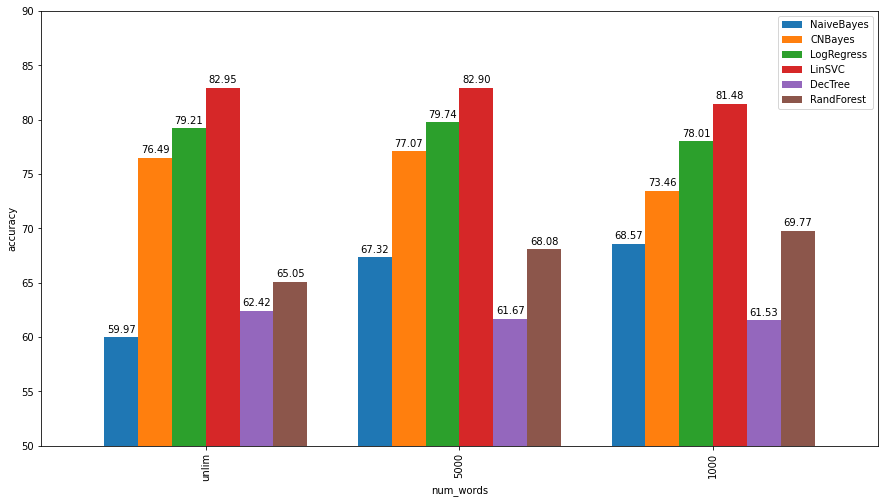

In [62]:
fig, ax = plt.subplots(figsize=(15, 8))

bars = df_acc.plot.bar(ax=ax, width=0.8)

ax.set_xlabel('num_words')
ax.set_ylabel('accuracy')
ax.set_ylim([50, 90])
ax.legend()

# 막대그래프에 실제 값을 표시하는 코드
for i, bar_group in enumerate(bars.containers):
    for bar in bar_group:
        height = bar.get_height()  # 막대의 높이(값)를 가져옵니다.
        ax.annotate(f'{height:.2f}',  # 높이(값)를 포맷하여 표시합니다.
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # 텍스트를 표시할 위치를 설정합니다.
                    xytext=(0, 3),  # 텍스트 위치를 막대 위로 조금 올립니다 (x, y 오프셋).
                    textcoords="offset points",  # 텍스트 위치의 기준을 설정합니다.
                    ha='center', va='bottom')  # 텍스트의 정렬을 중앙과 아래로 설정합니다.

plt.show()


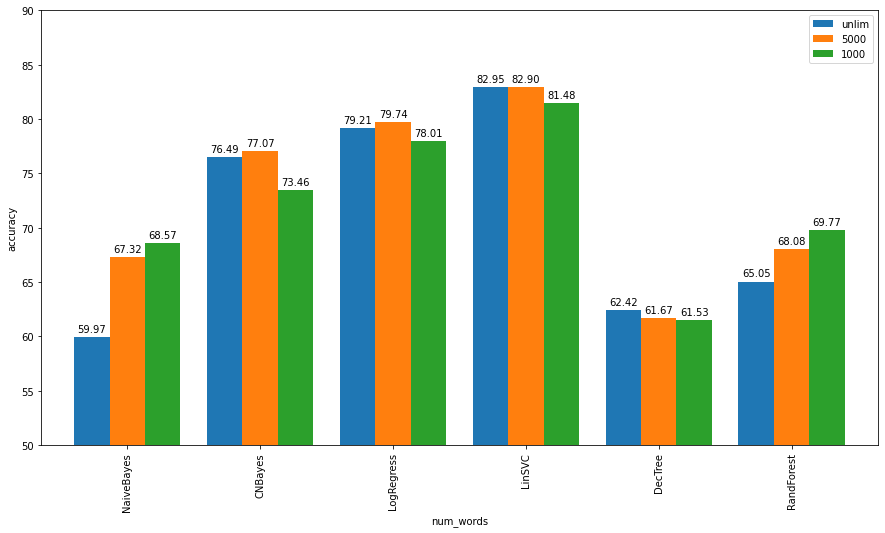

In [58]:
fig, ax = plt.subplots(figsize=(15, 8))

bars = df_acc.T.plot.bar(ax=ax, width=0.8)

ax.set_xlabel('num_words')
ax.set_ylabel('accuracy')
ax.set_ylim([50, 90])
ax.legend()

# 막대그래프에 실제 값을 표시하는 코드
for i, bar_group in enumerate(bars.containers):
    for bar in bar_group:
        height = bar.get_height()  # 막대의 높이(값)를 가져옵니다.
        ax.annotate(f'{height:.2f}',  # 높이(값)를 포맷하여 표시합니다.
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # 텍스트를 표시할 위치를 설정합니다.
                    xytext=(0, 3),  # 텍스트 위치를 막대 위로 조금 올립니다 (x, y 오프셋).
                    textcoords="offset points",  # 텍스트 위치의 기준을 설정합니다.
                    ha='center', va='bottom')  # 텍스트의 정렬을 중앙과 아래로 설정합니다.

plt.show()


정확도 측면에서 모든 단어를 사용한 선형 서포트 벡터 머신 모델이 가장 뛰어나지만, 단어를 5000개로 제한한 경우와 큰 차이는 나지 않는다.

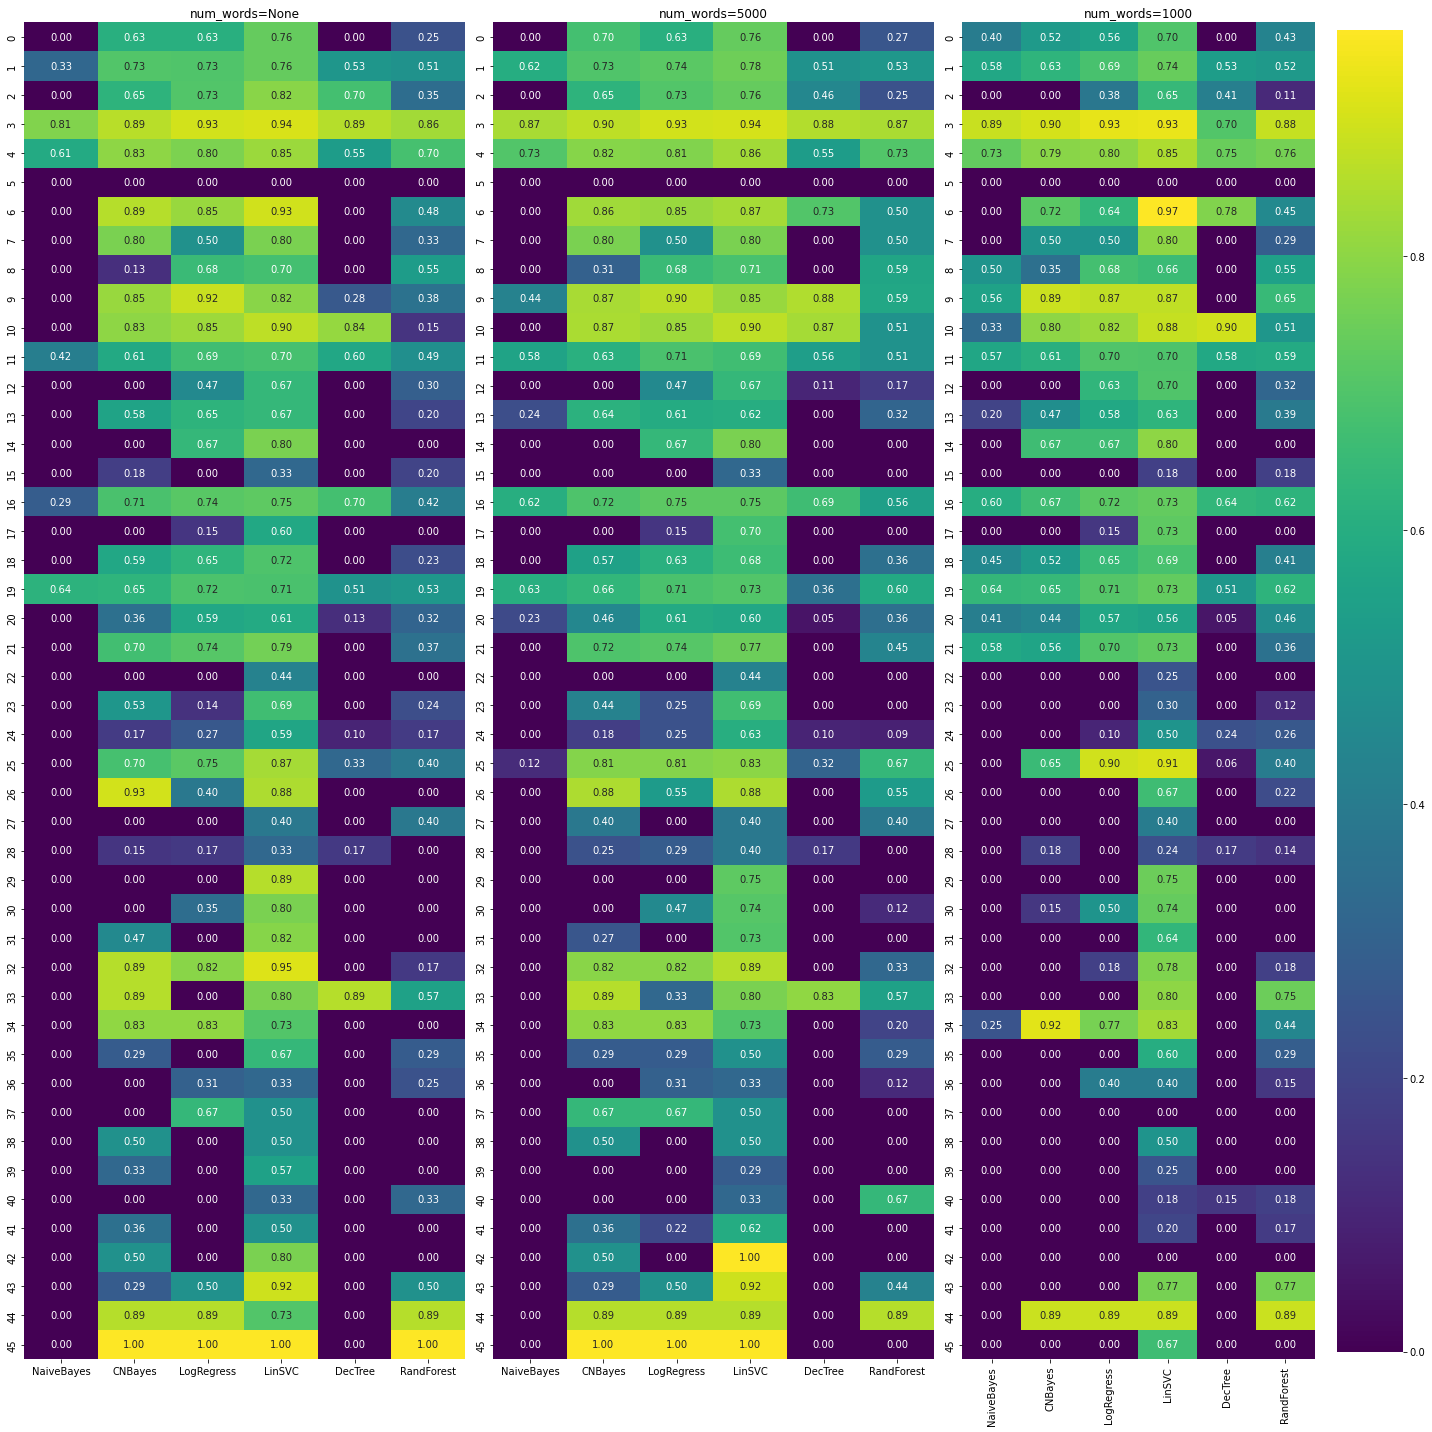

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))  # 1행에 3개의 히트맵을 그릴 예정입니다.

# 첫 번째 데이터프레임에 대한 히트맵
sns.heatmap(f1_unlim, ax=axes[0], cbar=False, annot=True, fmt=".2f", cmap='viridis')
axes[0].set_title('num_words=None')

# 두 번째 데이터프레임에 대한 히트맵
sns.heatmap(f1_5000, ax=axes[1], cbar=False, annot=True, fmt=".2f", cmap='viridis')
axes[1].set_title('num_words=5000')

# 세 번째 데이터프레임에 대한 히트맵
sns.heatmap(f1_1000, ax=axes[2], cbar=True, annot=True, fmt=".2f", cmap='viridis')
axes[2].set_title('num_words=1000')

# 히트맵들 사이의 공간을 조정합니다.
plt.tight_layout()

# 전체 피겨를 보여줍니다.
plt.show()

히트맵의 크기가 커서 한 눈에 들어오지는 않지만, 단어 수에 상관없이 선형 서포트 벡터 머신이 가장 좋은 F1-score를 기록하는 것으로 보인다. 선형 서포트 벡터 머신끼리 비교를 해보자.

In [60]:
df_f1 = pd.DataFrame(index=range(num_classes))
df_f1['unlim'] = f1_unlim['LinSVC']
df_f1['5000'] = f1_5000['LinSVC']
df_f1['1000'] = f1_1000['LinSVC']


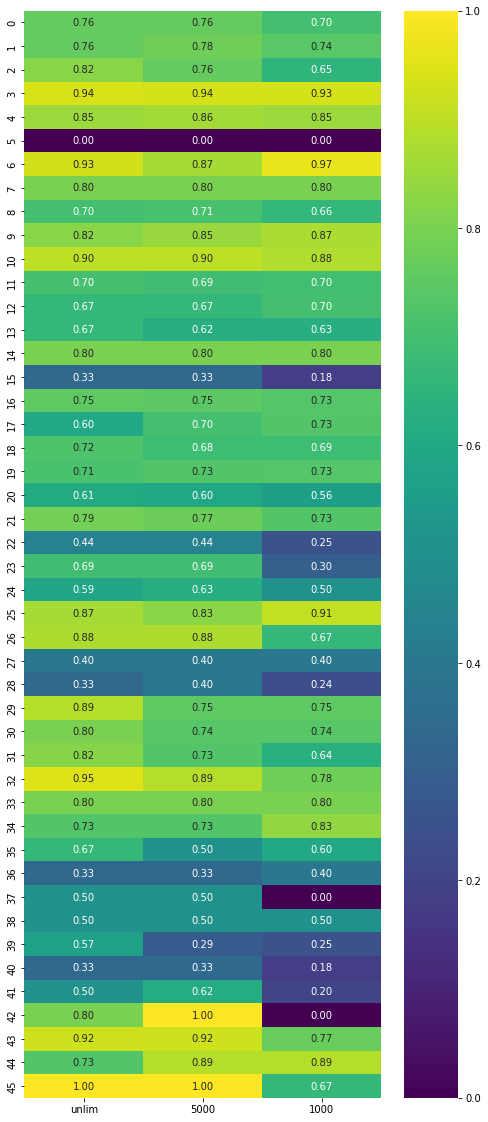

In [61]:
fig, ax = plt.subplots(figsize=(8, 20))  # 1행에 3개의 히트맵을 그릴 예정입니다.

sns.heatmap(df_f1, ax=ax, annot=True, fmt=".2f", cmap='viridis')
axes[0].set_title('F1-score for LinSVC')

plt.show()

역시 단어 개수에 대한 제한이 없는 경우와 5000개인 경우 비슷하게 좋은 성능을 보인다.

# 3. 딥러닝 모델을 이용한 뉴스 분류

단어수에 제한을 두지 않고 데이터를 불러와서 딥러닝 모델을 학습시키겠다.

In [98]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [99]:
# 데이터 개수 확인
len_train = len(x_train)
len_test = len(x_test)
print(len_train, len_test, len_train + len_test)

8982 2246 11228


In [100]:
x_total = np.concatenate([x_train, x_test])
x_total.shape

(11228,)

In [101]:
# vocab_size를 구하기 위해 인덱스의 최대값을 찾는다
max_index_value = max(max(sequence) for sequence in x_total if len(sequence) > 0)
vocab_size = max_index_value + 1 # 인덱스는 0부터 시작하므로 vocab_size를 구하려면 1을 더해야 한다
vocab_size

30982

문장의 최단 길이: 2
문장의 최장 길이: 2376
문장의 평균 길이: 145


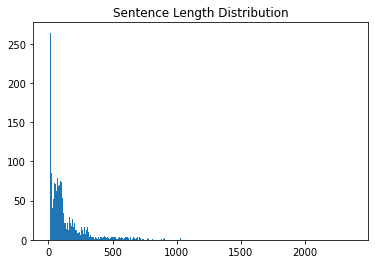

In [102]:
# 문장 길이에 대한 통계 확인
min_len = 999
max_len = 0
sum_len = 0

for sen in x_total:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(x_total))

sentence_length = np.zeros((max_len), dtype=int)

for sen in X:  
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [103]:
sum(sentence_length[:300])/len(x_total) # 전체 데이터 중 문장의 길이가 300 미만인 데이터의 비율

0.8884930530815818

문장의 길이가 300 미만인 데이터가 전체의 89%정도를 차지한다. 문장 최대 길이를 300으로 정하겠다.

In [104]:
# 긴 문장은 자르고 짧은 문장은 패딩
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_total_padded = pad_sequences(x_total, maxlen=300, truncating='post', padding='post')

In [105]:
# 전체 텍스트 데이터를 다시 학습 / 테스트로 나누기
x_train = x_total_padded[:len_train]
x_test = x_total_padded[len_train:]

In [106]:
x_train.shape

(8982, 300)

In [109]:
# 타겟 데이터의 분포의 불균형성을 고려하여 검증 데이터를 분리한다
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [173]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization

embedding_dim = 50 
max_len = 300
lstm_units = 50

model_lstm = Sequential()

model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len, mask_zero=True))

model_lstm.add(LSTM(lstm_units))
model_lstm.add(Dropout(0.4))
model_lstm.add(BatchNormalization())

model_lstm.add(Dense(60, activation='relu'))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 300, 50)           1549100   
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 50)                200       
_________________________________________________________________
dense_48 (Dense)             (None, 60)                3060      
_________________________________________________________________
dense_49 (Dense)             (None, 46)                2806      
Total params: 1,575,366
Trainable params: 1,575,266
Non-trainable params: 100
_________________________________________

In [174]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(x_train, y_train, epochs=50, batch_size = 128, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 6s 37ms/step - loss: 2.8970 - accuracy: 0.3389 - val_loss: 2.6381 - val_accuracy: 0.5231
Epoch 2/50
57/57 [==============================] - 1s 17ms/step - loss: 1.8984 - accuracy: 0.5339 - val_loss: 2.4950 - val_accuracy: 0.5281
Epoch 3/50
57/57 [==============================] - 1s 17ms/step - loss: 1.5343 - accuracy: 0.6040 - val_loss: 2.2193 - val_accuracy: 0.5671
Epoch 4/50
57/57 [==============================] - 1s 17ms/step - loss: 1.2997 - accuracy: 0.6592 - val_loss: 2.0820 - val_accuracy: 0.6032
Epoch 5/50
57/57 [==============================] - 1s 17ms/step - loss: 1.1227 - accuracy: 0.6998 - val_loss: 1.7193 - val_accuracy: 0.6210
Epoch 6/50
57/57 [==============================] - 1s 17ms/step - loss: 0.9619 - accuracy: 0.7404 - val_loss: 1.6138 - val_accuracy: 0.6311
Epoch 7/50
57/57 [==============================] - 1s 17ms/step - loss: 0.8340 - accuracy: 0.7756 - val_loss: 1.5824 - val_accuracy: 0.6355
Epoch 8/50
57

In [176]:
model_lstm.evaluate(x_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 1.5708 - accuracy: 0.6296


[1.5707519054412842, 0.6295636892318726]

간단한 LSTM 모델에서 약 63%의 정확도를 보였다.

In [177]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

embedding_dim = 50 
max_len = 300
filters = 30
kernel_size=5
pool_size=5

model_conv = Sequential()

model_conv.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

model_conv.add(Conv1D(filters, kernel_size, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=pool_size))

model_conv.add(GlobalAveragePooling1D())

model_conv.add(Dense(num_classes, activation='softmax'))

model_conv.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 300, 50)           1549100   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 296, 30)           7530      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 59, 30)            0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 30)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 46)                1426      
Total params: 1,558,056
Trainable params: 1,558,056
Non-trainable params: 0
_________________________________________________________________


In [178]:
model_conv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_conv.fit(x_train, y_train, epochs=100, batch_size = 128, validation_data=(x_val, y_val), callbacks=[early_stopping])


Epoch 1/100
57/57 [==============================] - 1s 8ms/step - loss: 3.4416 - accuracy: 0.3368 - val_loss: 2.5694 - val_accuracy: 0.3517
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 2.3119 - accuracy: 0.3733 - val_loss: 2.2029 - val_accuracy: 0.3812
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 2.1238 - accuracy: 0.4118 - val_loss: 2.0830 - val_accuracy: 0.4502
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 1.9870 - accuracy: 0.4757 - val_loss: 1.9538 - val_accuracy: 0.5086
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 1.8335 - accuracy: 0.5454 - val_loss: 1.8173 - val_accuracy: 0.5531
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 1.6909 - accuracy: 0.5865 - val_loss: 1.7074 - val_accuracy: 0.5838
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 1.5779 - accuracy: 0.6212 - val_loss: 1.6253 - val_accuracy: 0.6066
Epoch 8/100
5

In [179]:
model_conv.evaluate(x_test, y_test)

71/71 [==============================] - 0s 2ms/step - loss: 1.2033 - accuracy: 0.7333


[1.2033003568649292, 0.7333036661148071]

1차원 합성곱 신경망 모델에서는 약 73%의 정확도를 보였다.

# 회고
- 딥러닝 모델이 선형 서포트 벡터 머신 모델보다 정확도가 떨어지는 것을 볼 수 있었다. 딥러닝 모델이 효과적이기 위해서는 데이터가 훨씬 더 많아야 할 것이라고 생각된다. 데이터가 적은 경우 일반적인 머신러닝 모델이 학습 속도도 빠르고 성능도 뒤쳐지지 않거나 오히려 더 좋을 수 있다.
- 다양한 모델의 학습 결과를 적절하게 시각화하는 것이 중요하다. 비교 대상이 많을수록 한 눈에 파악하기 쉬운 형태의 그래프를 선택하는 것이 중요해진다. 
- 딥러닝 모델의 경우 모델을 어떤 식으로 정의하는 것이 가장 좋을지에 대해 시행착오를 겪는데, 이 과정을 전부 기록으로 남기면 오히려 가독성이 떨어진다고 생각해서 여러 시도 끝에 가장 적당한 모델만을 기록했다. 만약 프로젝트의 초점이 적절한 딥러닝 모델을 찾아내는 것에 맞춰져 있다면 이런 기록들을 남기고 종합하여 시각화하는 과정이 필요할 것이다.